In [2]:
!pip install SimpleITK --break-system-packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.5/38.5 MB 34.4 MB/s  0:00:01 33.9 MB/s eta 0:00:01


In [4]:
!pip install seaborn --break-system-packages

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [5]:
# Data handling
import pandas as pd
import numpy as np
import os

# Medical image processing
import SimpleITK as sitk

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)

print(" All libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

 All libraries imported successfully!
Working directory: /Users/rithika/Documents/lung-nodule-segmentation-uncertainty/notebooks


In [6]:
# Define data paths
DATA_DIR = '../data/raw/'
ANNOTATIONS_PATH = os.path.join(DATA_DIR, 'annotations.csv')
CANDIDATES_PATH = os.path.join(DATA_DIR, 'candidates.csv')

# Load CSV files
annotations_df = pd.read_csv(ANNOTATIONS_PATH)
candidates_df = pd.read_csv(CANDIDATES_PATH)

# Display basic info
print("=" * 60)
print("ANNOTATIONS (Real Nodules)")
print("=" * 60)
print(f"Total annotations: {len(annotations_df)}")
print(f"\nFirst few rows:")
print(annotations_df.head())

print("\n" + "=" * 60)
print("CANDIDATES (Real + False Positives)")
print("=" * 60)
print(f"Total candidates: {len(candidates_df)}")
print(f"\nClass distribution:")
print(candidates_df['class'].value_counts())
print(f"\nFirst few rows:")
print(candidates_df.head())

ANNOTATIONS (Real Nodules)
Total annotations: 1186

First few rows:
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  

CANDIDATES (Real + False Positives)
Total candidates: 551065

Class distribution:
class
0    549714
1      1351
Name: count, dtype: int64

First few rows:
                                           seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.1002

/var/folders/zw/2nxw1ww56078pvzc63bgtxb40000gn/T/ipykernel_9979/2352725380.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[1], palette=['#ff6b6b', '#4ecdc4'])
/var/folders/zw/2nxw1ww56078pvzc63bgtxb40000gn/T/ipykernel_9979/2352725380.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['False Positive (0)', 'True Nodule (1)'])


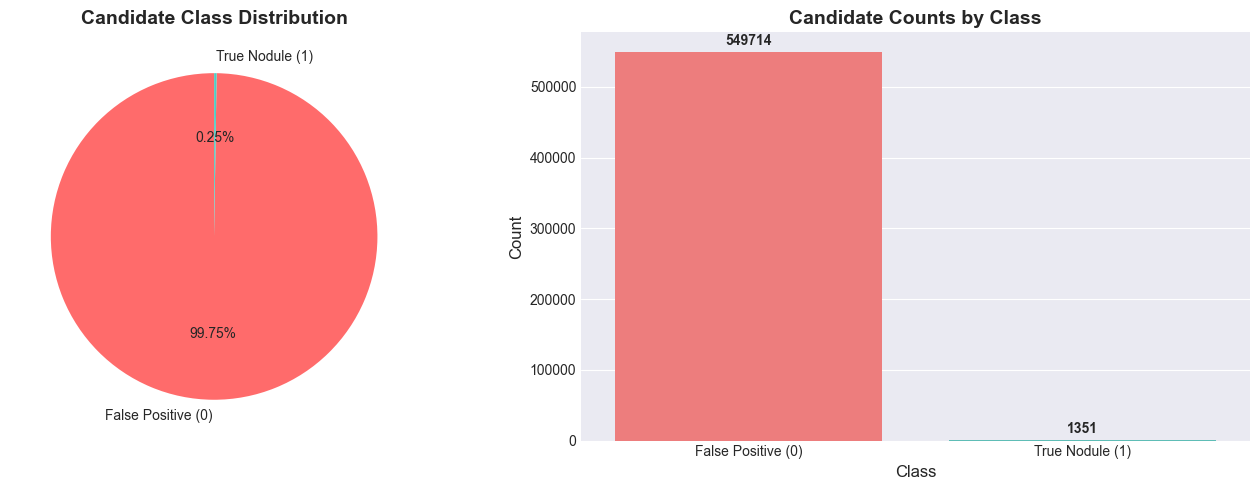


 Key Finding: This is a highly imbalanced dataset!
   → False Positives: 549,714 (99.75%)
   → True Nodules: 1,351 (0.25%)

 This is realistic! In medical imaging, most candidates are false positives.


In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
class_counts = candidates_df['class'].value_counts()
axes[0].pie(class_counts, labels=['False Positive (0)', 'True Nodule (1)'], 
            autopct='%1.2f%%', startangle=90, colors=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Candidate Class Distribution', fontsize=14, fontweight='bold')

# Bar chart
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[1], palette=['#ff6b6b', '#4ecdc4'])
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Candidate Counts by Class', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['False Positive (0)', 'True Nodule (1)'])

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    axes[1].text(i, v + 10000, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Key Finding: This is a highly imbalanced dataset!")
print(f"   → False Positives: {class_counts[0]:,} ({class_counts[0]/len(candidates_df)*100:.2f}%)")
print(f"   → True Nodules: {class_counts[1]:,} ({class_counts[1]/len(candidates_df)*100:.2f}%)")
print("\n This is realistic! In medical imaging, most candidates are false positives.")

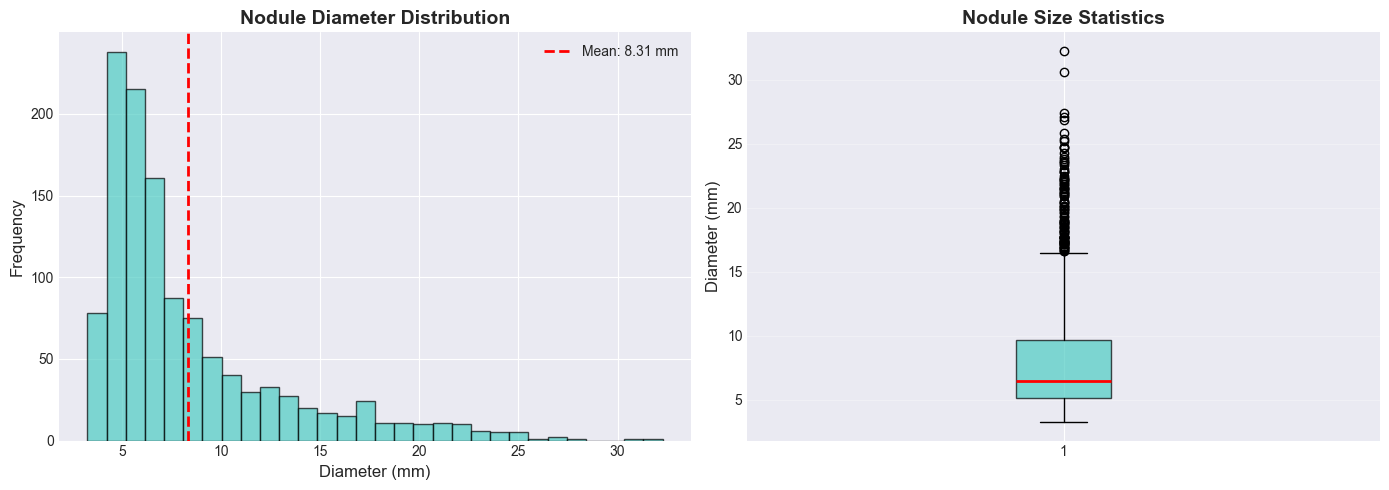

 Nodule Size Statistics:
   Mean diameter: 8.31 mm
   Median diameter: 6.43 mm
   Min diameter: 3.25 mm
   Max diameter: 32.27 mm
   Std deviation: 4.76 mm

 Clinical Context:
   • Nodules < 6mm: Usually benign, monitored
   • Nodules 6-8mm: Require follow-up
   • Nodules > 8mm: Higher concern, may need biopsy

   Distribution in dataset:
   • Small (<6mm): 502 (42.3%)
   • Medium (6-8mm): 276 (23.3%)
   • Large (>8mm): 408 (34.4%)


In [9]:
# Analyze nodule diameter distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(annotations_df['diameter_mm'], bins=30, color='#4ecdc4', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Diameter (mm)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Nodule Diameter Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(annotations_df['diameter_mm'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {annotations_df["diameter_mm"].mean():.2f} mm')
axes[0].legend()

# Box plot
axes[1].boxplot(annotations_df['diameter_mm'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#4ecdc4', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Diameter (mm)', fontsize=12)
axes[1].set_title('Nodule Size Statistics', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(" Nodule Size Statistics:")
print(f"   Mean diameter: {annotations_df['diameter_mm'].mean():.2f} mm")
print(f"   Median diameter: {annotations_df['diameter_mm'].median():.2f} mm")
print(f"   Min diameter: {annotations_df['diameter_mm'].min():.2f} mm")
print(f"   Max diameter: {annotations_df['diameter_mm'].max():.2f} mm")
print(f"   Std deviation: {annotations_df['diameter_mm'].std():.2f} mm")

# Clinical context
print("\n Clinical Context:")
print("   • Nodules < 6mm: Usually benign, monitored")
print("   • Nodules 6-8mm: Require follow-up")
print("   • Nodules > 8mm: Higher concern, may need biopsy")
small = (annotations_df['diameter_mm'] < 6).sum()
medium = ((annotations_df['diameter_mm'] >= 6) & (annotations_df['diameter_mm'] <= 8)).sum()
large = (annotations_df['diameter_mm'] > 8).sum()
print(f"\n   Distribution in dataset:")
print(f"   • Small (<6mm): {small} ({small/len(annotations_df)*100:.1f}%)")
print(f"   • Medium (6-8mm): {medium} ({medium/len(annotations_df)*100:.1f}%)")
print(f"   • Large (>8mm): {large} ({large/len(annotations_df)*100:.1f}%)")

Loading scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
 Found: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd

 Loading CT scan...

 Scan Properties:
   Shape (slices, height, width): (194, 512, 512)
   Spacing (mm): (0.64453125, 0.64453125, 1.7999999523162842)
   Origin (mm): (-157.67773, -311.67773, -438.4)
   Voxel values range: [0, 5]
   Data type: int16


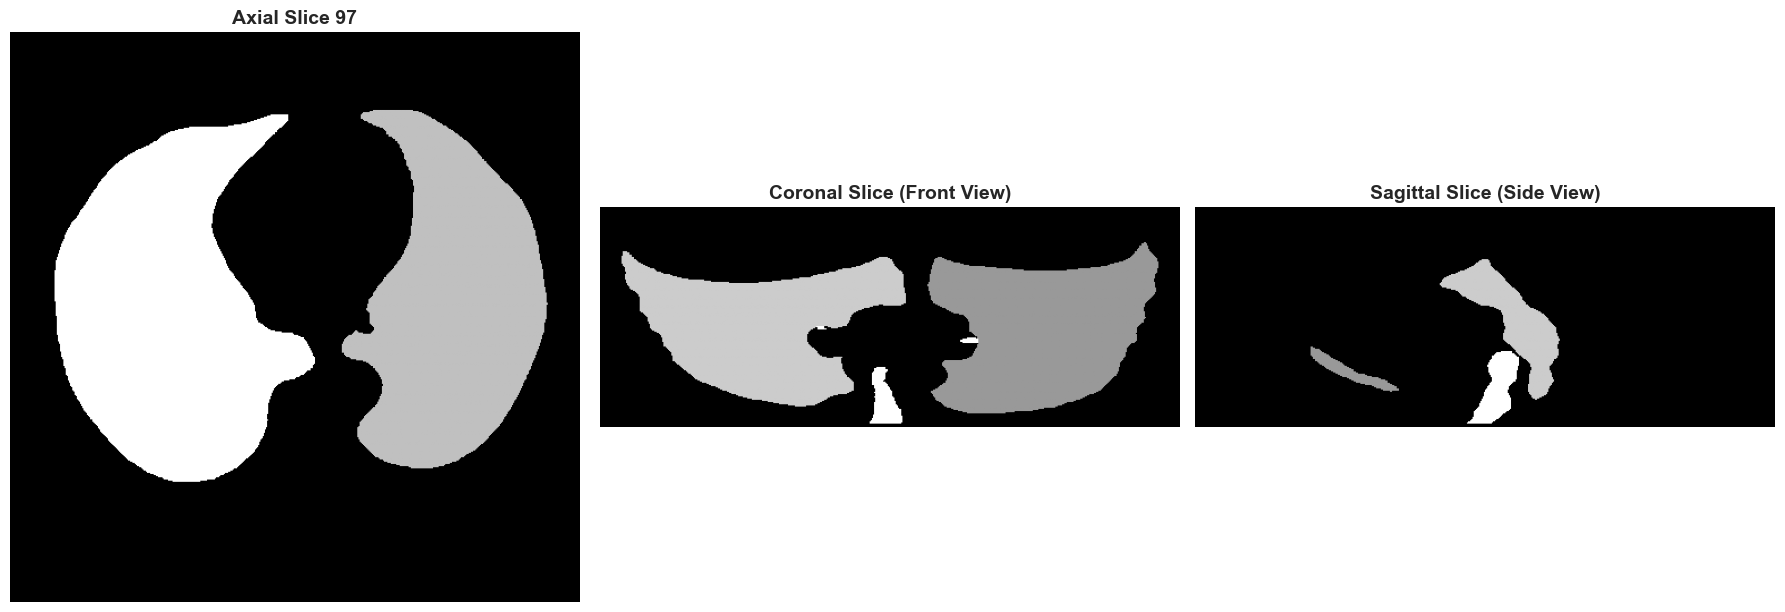


 Successfully loaded and visualized CT scan!
   You can see the lungs (dark regions) and surrounding structures


In [10]:
# Get a sample scan with nodules
sample_series = annotations_df['seriesuid'].iloc[0]
print(f"Loading scan: {sample_series}")

# Find the .mhd file
scan_files = [f for f in os.listdir(DATA_DIR + 'seg-lungs-LUNA16/seg-lungs-LUNA16/') 
              if f.startswith(sample_series) and f.endswith('.mhd')]

if scan_files:
    scan_path = os.path.join(DATA_DIR, 'seg-lungs-LUNA16/seg-lungs-LUNA16/', scan_files[0])
    print(f" Found: {scan_files[0]}")
    
    # Load CT scan using SimpleITK
    print("\n Loading CT scan...")
    ct_scan = sitk.ReadImage(scan_path)
    ct_array = sitk.GetArrayFromImage(ct_scan)
    
    # Get scan properties
    print(f"\n Scan Properties:")
    print(f"   Shape (slices, height, width): {ct_array.shape}")
    print(f"   Spacing (mm): {ct_scan.GetSpacing()}")
    print(f"   Origin (mm): {ct_scan.GetOrigin()}")
    print(f"   Voxel values range: [{ct_array.min()}, {ct_array.max()}]")
    print(f"   Data type: {ct_array.dtype}")
    
    # Visualize middle slice
    middle_slice = ct_array.shape[0] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Axial view (top-down)
    axes[0].imshow(ct_array[middle_slice, :, :], cmap='gray')
    axes[0].set_title(f'Axial Slice {middle_slice}', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Coronal view (front)
    axes[1].imshow(ct_array[:, ct_array.shape[1]//2, :], cmap='gray')
    axes[1].set_title('Coronal Slice (Front View)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Sagittal view (side)
    axes[2].imshow(ct_array[:, :, ct_array.shape[2]//2], cmap='gray')
    axes[2].set_title('Sagittal Slice (Side View)', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n Successfully loaded and visualized CT scan!")
    print("   You can see the lungs (dark regions) and surrounding structures")
    
else:
    print(" Scan file not found!")

In [12]:
# Check if we have the original CT scans
print(" Checking available files...")
all_files = os.listdir(DATA_DIR + 'seg-lungs-LUNA16/seg-lungs-LUNA16/')
print(f"\nTotal files: {len(all_files)}")

# Check file types
mhd_files = [f for f in all_files if f.endswith('.mhd')]
zraw_files = [f for f in all_files if f.endswith('.zraw')]

print(f"\n.mhd files (headers): {len(mhd_files)}")
print(f".zraw files (raw data): {len(zraw_files)}")

# Sample a few filenames to understand naming pattern
print(f"\nSample filenames:")
for i, f in enumerate(mhd_files[:3]):
    print(f"   {i+1}. {f}")
    
print("\n Analysis:")
print("   These appear to be LUNG SEGMENTATION MASKS, not raw CT scans.")
print("   For nodule detection, we typically need the original CT with HU values.")

 Checking available files...

Total files: 1776

.mhd files (headers): 888
.zraw files (raw data): 888

Sample filenames:
   1. 1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
   2. 1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770.mhd
   3. 1.3.6.1.4.1.14519.5.2.1.6279.6001.190144948425835566841437565646.mhd

 Analysis:
   These appear to be LUNG SEGMENTATION MASKS, not raw CT scans.
   For nodule detection, we typically need the original CT with HU values.


In [14]:
# Summary of data exploration
print("=" * 70)
print("DATA EXPLORATION SUMMARY")
print("=" * 70)

print("\n Dataset Contents:")
print(f"   • CT Scans (lung masks): {len(mhd_files)}")
print(f"   • Real nodule annotations: {len(annotations_df)}")
print(f"   • Candidate locations: {len(candidates_df):,}")
print(f"   • True positives: {(candidates_df['class']==1).sum():,}")
print(f"   • False positives: {(candidates_df['class']==0).sum():,}")

print("\n Nodule Characteristics:")
print(f"   • Size range: {annotations_df['diameter_mm'].min():.2f} - {annotations_df['diameter_mm'].max():.2f} mm")
print(f"   • Mean size: {annotations_df['diameter_mm'].mean():.2f} mm")
print(f"   • Small nodules (<6mm): {(annotations_df['diameter_mm'] < 6).sum()} ({(annotations_df['diameter_mm'] < 6).sum()/len(annotations_df)*100:.1f}%)")
print(f"   • Large nodules (>8mm): {(annotations_df['diameter_mm'] > 8).sum()} ({(annotations_df['diameter_mm'] > 8).sum()/len(annotations_df)*100:.1f}%)")

print("\n Next Steps:")
print("   1. Extract nodule regions from CT scans using coordinates")
print("   2. Create training patches (nodule vs non-nodule)")
print("   3. Build U-Net segmentation model")
print("   4. Implement uncertainty quantification (Monte Carlo Dropout)")
print("   5. Visualize predictions with uncertainty maps")

print("\n" + "=" * 70)

DATA EXPLORATION SUMMARY

 Dataset Contents:
   • CT Scans (lung masks): 888
   • Real nodule annotations: 1186
   • Candidate locations: 551,065
   • True positives: 1,351
   • False positives: 549,714

 Nodule Characteristics:
   • Size range: 3.25 - 32.27 mm
   • Mean size: 8.31 mm
   • Small nodules (<6mm): 502 (42.3%)
   • Large nodules (>8mm): 408 (34.4%)

 Next Steps:
   1. Extract nodule regions from CT scans using coordinates
   2. Create training patches (nodule vs non-nodule)
   3. Build U-Net segmentation model
   4. Implement uncertainty quantification (Monte Carlo Dropout)
   5. Visualize predictions with uncertainty maps

